In [1]:
import scib
import latentvelo as ltv
import scanpy as sc
import scvelo as scv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Global seed set to 0


# Read process and plot data

In [2]:
adata = sc.read('../synthetic_datasets/bifurcation_2batches.h5ad')

In [3]:
ltv.utils.anvi_clean_recipe(adata, spliced_key='counts_spliced', unspliced_key='counts_unspliced',
                                 batch_key = 'batch', umap=True, celltype_key='milestone')

Skip filtering by dispersion since number of variables are less than `n_top_genes`.
computing neighbors
    finished (0:00:10) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


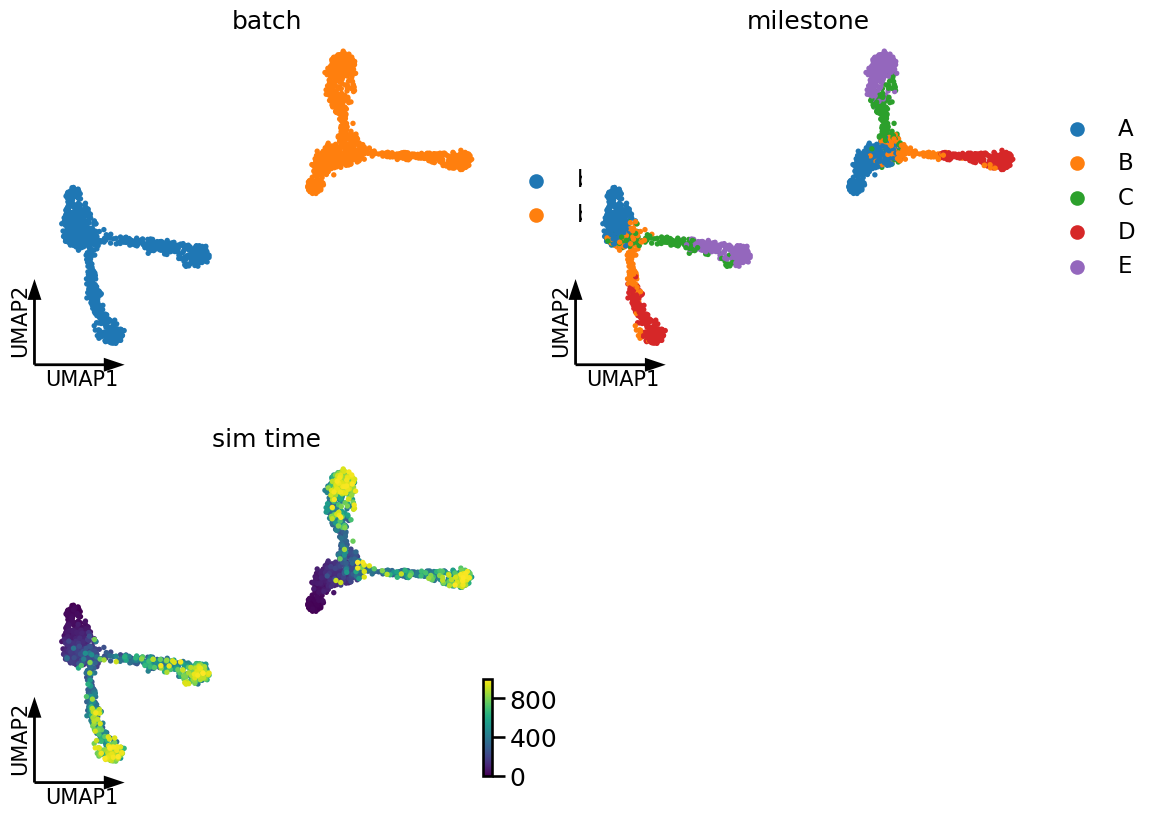

In [4]:
scv.pl.umap(adata, color=['batch', 'milestone', 'sim_time'], frameon='artist', legend_loc='right', ncols=2)

# Train VAE model for batch correction

In [5]:
model = ltv.models.VAE(observed=85, latent_dim=20, zr_dim=1,
                              batch_correction=True, batches=2)

In [6]:
epochs, val_ae, val_traj = ltv.train(model, adata, batch_size = 100,
                                      epochs=50, name='batch_correction_bifurcation_params')

44 velocity genes used
epoch 0, full loss 182.708, val loss 77.369, recon MSE 0.492, traj MSE 0.452, reg loss -3.382
epoch 1, full loss 93.936, val loss 48.379, recon MSE 0.396, traj MSE 0.289, reg loss -2.391
epoch 2, full loss 76.763, val loss 28.892, recon MSE 0.294, traj MSE 0.251, reg loss -2.879
epoch 3, full loss 57.786, val loss 10.567, recon MSE 0.268, traj MSE 0.237, reg loss -2.579
epoch 4, full loss 40.484, val loss -4.774, recon MSE 0.256, traj MSE 0.234, reg loss -3.196
epoch 5, full loss 26.444, val loss -17.421, recon MSE 0.217, traj MSE 0.214, reg loss -3.765
epoch 6, full loss 14.946, val loss -28.163, recon MSE 0.196, traj MSE 0.190, reg loss -3.990
epoch 7, full loss 4.420, val loss -36.819, recon MSE 0.181, traj MSE 0.176, reg loss -3.942
epoch 8, full loss -4.412, val loss -44.540, recon MSE 0.173, traj MSE 0.176, reg loss -3.814
epoch 9, full loss -12.141, val loss -50.545, recon MSE 0.167, traj MSE 0.168, reg loss -3.544
epoch 10, full loss -18.389, val loss -56

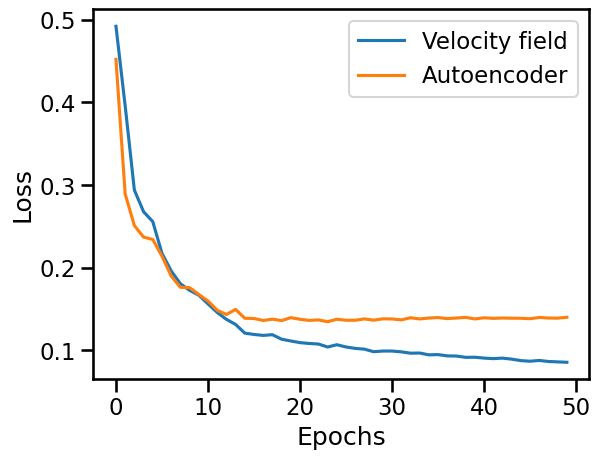

In [7]:
ltv.plot_history(epochs, val_ae, val_traj)
plt.show()

# Train annotated VAE model for batch correction

In [8]:
annot_model = ltv.models.AnnotVAE(observed=85, latent_dim=20, zr_dim=1,
                              batch_correction=True, batches=2, celltypes=len(adata.obs.milestone.unique()))

In [9]:
epochs, val_ae, val_traj = ltv.train_anvi(annot_model, adata, batch_size = 100, shuffle=False,
                                      epochs=50, name='batch_correction_bifurcation_annot_params')

44 velocity genes used
epoch 0, full loss 184.127, val loss 79.022, ae MSE 0.424, traj MSE 0.478, reg loss -3.278
epoch 1, full loss 50.342, val loss 46.186, ae MSE 0.334, traj MSE 0.254, reg loss -3.558
epoch 2, full loss 23.323, val loss 24.167, ae MSE 0.249, traj MSE 0.230, reg loss -3.477
epoch 3, full loss 4.387, val loss 6.989, ae MSE 0.237, traj MSE 0.224, reg loss -3.310
epoch 4, full loss -8.119, val loss -6.701, ae MSE 0.227, traj MSE 0.218, reg loss -3.456
epoch 5, full loss -17.502, val loss -17.602, ae MSE 0.217, traj MSE 0.210, reg loss -3.703
epoch 6, full loss -28.364, val loss -27.025, ae MSE 0.208, traj MSE 0.195, reg loss -3.534
epoch 7, full loss -35.712, val loss -35.599, ae MSE 0.199, traj MSE 0.182, reg loss -3.773
epoch 8, full loss -44.936, val loss -43.648, ae MSE 0.187, traj MSE 0.173, reg loss -3.903
epoch 9, full loss -52.037, val loss -51.044, ae MSE 0.186, traj MSE 0.170, reg loss -4.292
epoch 10, full loss -58.906, val loss -58.165, ae MSE 0.180, traj MS

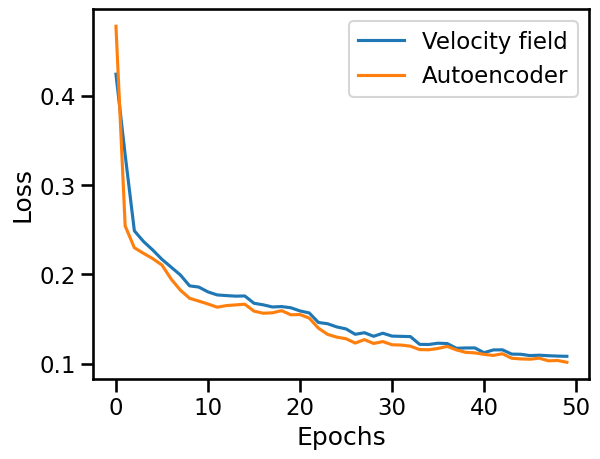

In [10]:
ltv.plot_history(epochs, val_ae, val_traj)
plt.show()

# Get outputs for both models

In [11]:
latent_adata = ltv.output_results(model, adata)

In [12]:
annot_latent_adata = ltv.output_results(annot_model, adata, annot=True)

In [13]:
scv.tl.velocity_graph(latent_adata, vkey='spliced_velocity')
scv.tl.velocity_graph(annot_latent_adata, vkey='spliced_velocity')

computing velocity graph (using 1/16 cores)


  0%|          | 0/2000 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'spliced_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity graph (using 1/16 cores)


  0%|          | 0/2000 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'spliced_velocity_graph', sparse matrix with cosine correlations (adata.uns)


# Plot VAE model on original unintegrated space

computing velocity embedding
    finished (0:00:00) --> added
    'spliced_velocity_umap', embedded velocity vectors (adata.obsm)


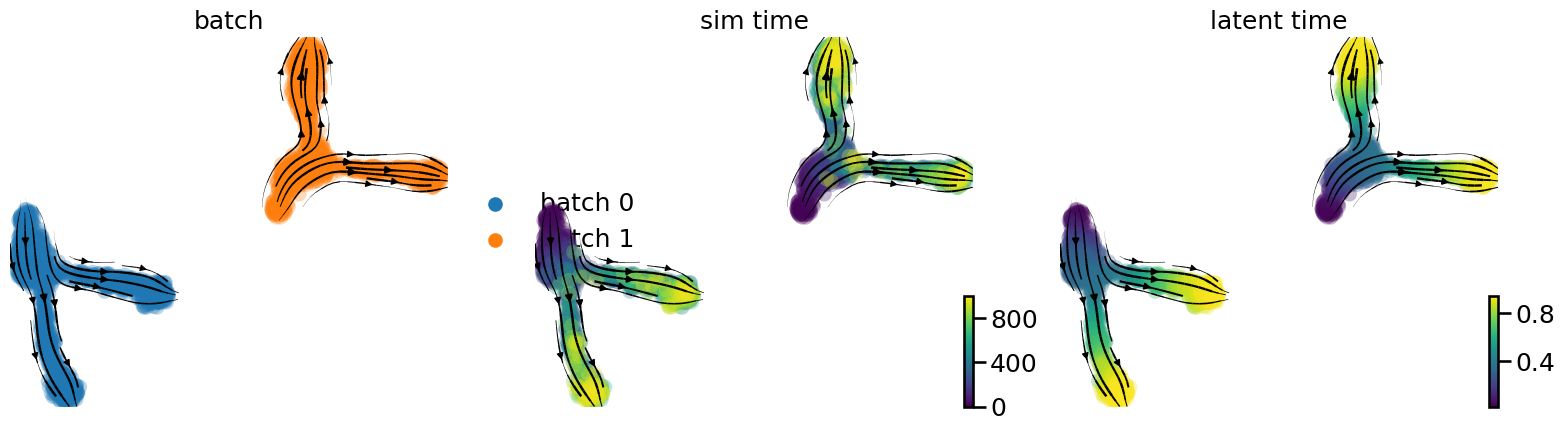

In [14]:
scv.pl.velocity_embedding_stream(latent_adata, vkey='spliced_velocity', 
                                 color=['batch', 'sim_time', 'latent_time']
                                , legend_loc='right', legend_fontsize=18)

# Plot annotated VAE model on original unintegrated space

computing velocity embedding
    finished (0:00:00) --> added
    'spliced_velocity_umap', embedded velocity vectors (adata.obsm)


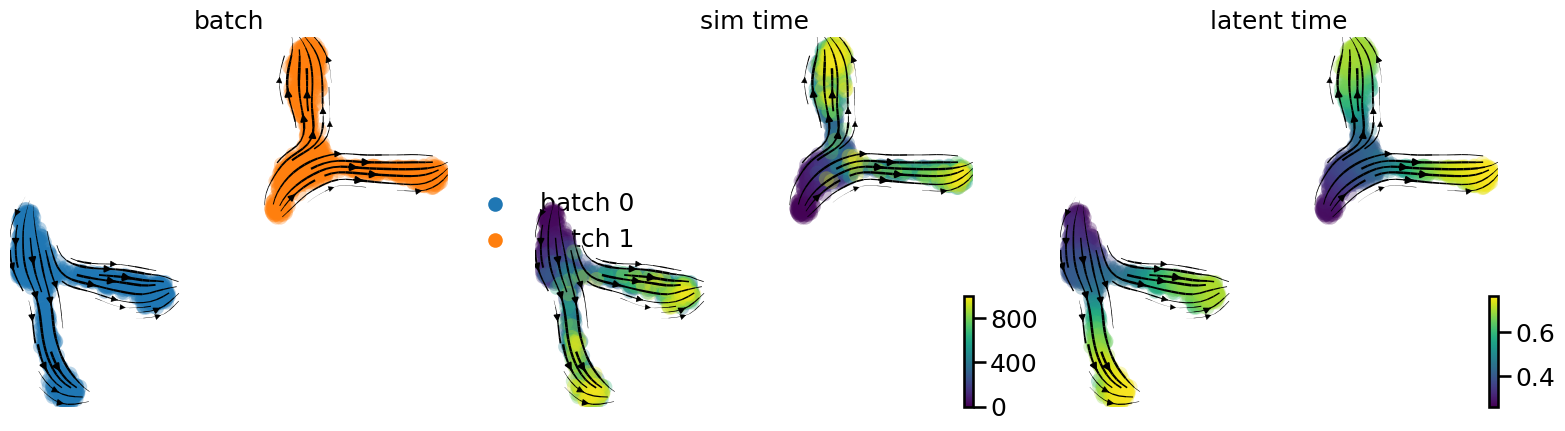

In [15]:
scv.pl.velocity_embedding_stream(annot_latent_adata, vkey='spliced_velocity', 
                                 color=['batch', 'sim_time', 'latent_time']
                                , legend_loc='right', legend_fontsize=18)

# Plot VAE model on integrated latent space

computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocity graph (using 1/16 cores)


  0%|          | 0/2000 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'spliced_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'spliced_velocity_umap', embedded velocity vectors (adata.obsm)


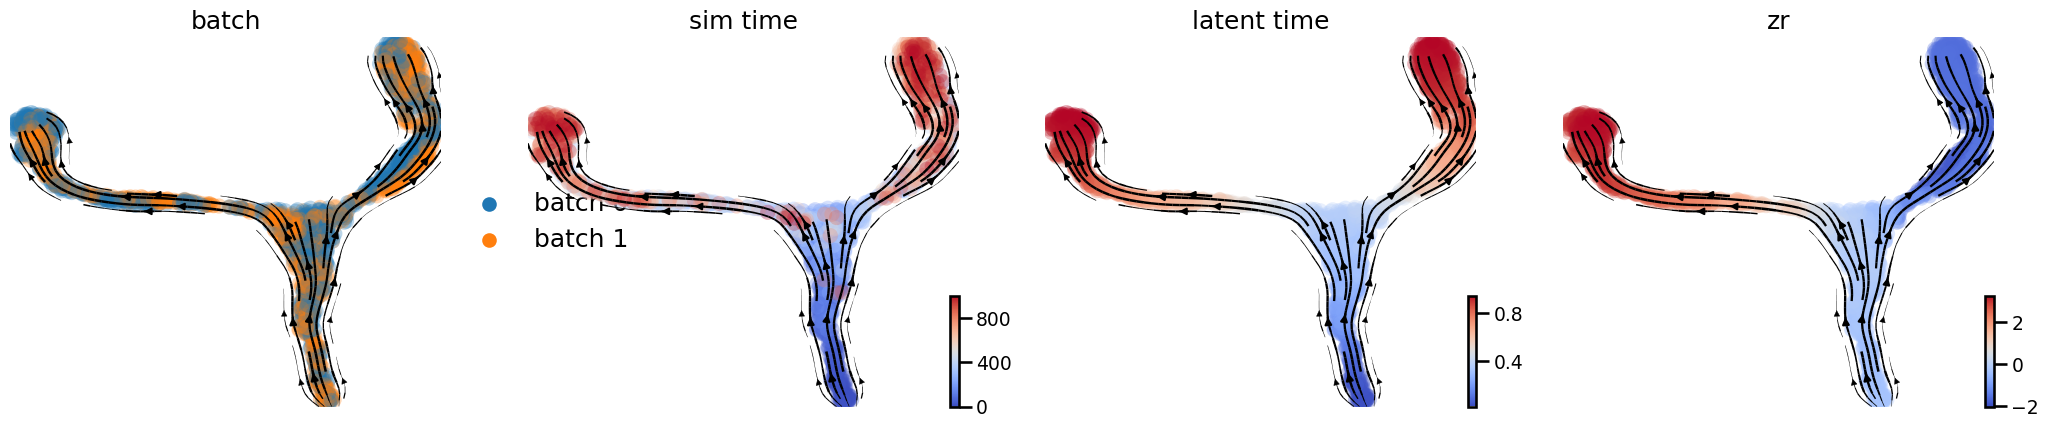

In [16]:
latent_adata.obs['zr'] = latent_adata.obsm['zr'][:,0]
scv.pp.neighbors(latent_adata, use_rep='X', n_neighbors=30)
scv.tl.umap(latent_adata)
scv.tl.velocity_graph(latent_adata, vkey='spliced_velocity')
scv.pl.velocity_embedding_stream(latent_adata, vkey='spliced_velocity', 
                                 color=['batch', 'sim_time', 'latent_time', 'zr'], legend_loc='right',
                                legend_fontsize=18, fontsize=18, color_map='coolwarm')


# Plot annotated VAE model on integrated space

computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocity graph (using 1/16 cores)


  0%|          | 0/2000 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'spliced_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'spliced_velocity_umap', embedded velocity vectors (adata.obsm)


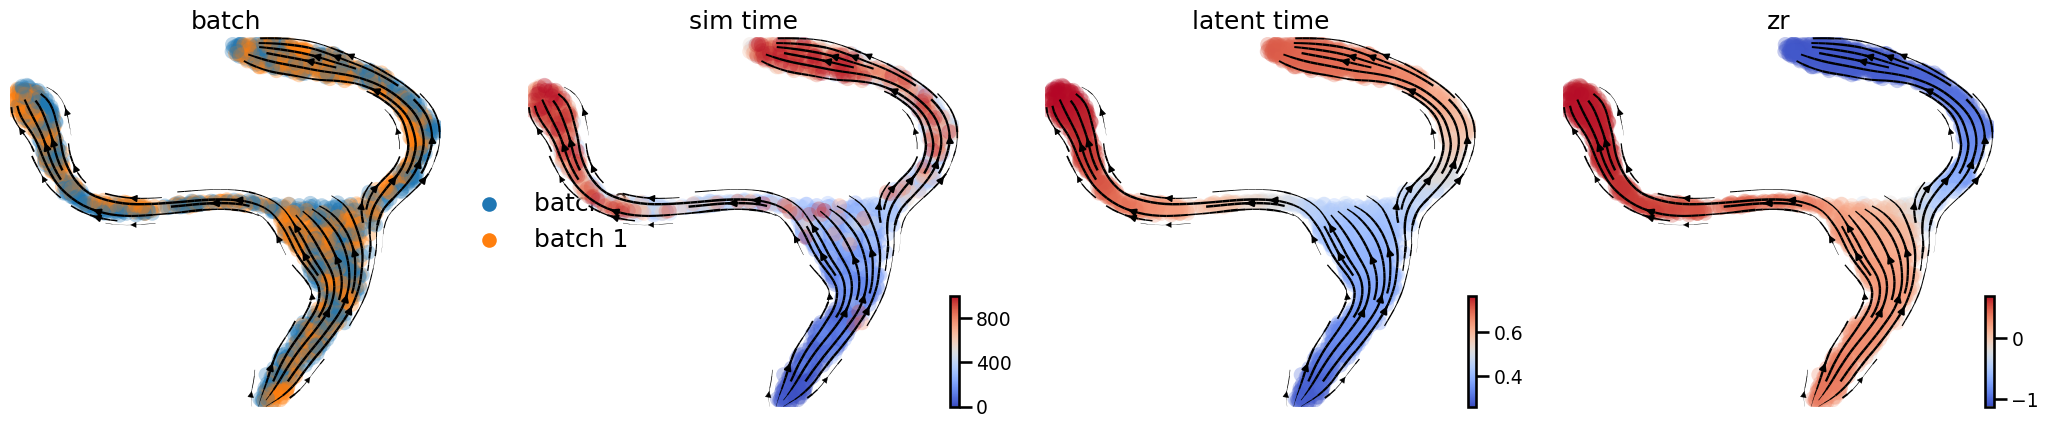

In [17]:
annot_latent_adata.obs['zr'] = annot_latent_adata.obsm['zr'][:,0]
scv.pp.neighbors(annot_latent_adata, use_rep='X', n_neighbors=30)
scv.tl.umap(annot_latent_adata)
scv.tl.velocity_graph(annot_latent_adata, vkey='spliced_velocity')
scv.pl.velocity_embedding_stream(annot_latent_adata, vkey='spliced_velocity', 
                                 color=['batch', 'sim_time', 'latent_time', 'zr'], legend_loc='right',
                                legend_fontsize=18, fontsize=18, color_map='coolwarm')

# Compute gene-expression batch correction metrics

In [18]:
latent_adata.obsm['X_latent'] = latent_adata.X.copy()
ge_metrics = ltv.ev.integration_metrics(latent_adata, label_key='milestone', 
                                         batch_key = 'batch', emb_key='X_latent')

annot_latent_adata.obsm['X_latent'] = annot_latent_adata.X.copy()
annot_ge_metrics = ltv.ev.integration_metrics(annot_latent_adata, label_key='milestone', 
                                         batch_key = 'batch', emb_key='X_latent')

computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
Adding diffusion to step 4
Adding diffusion to step 5
Adding diffusion to step 4
Adding diffusion to step 5
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
Adding diffusion to step 4
Adding diffusion to step 4
Adding diffusion to step 5
Adding diffusion to step 4
Adding diffusion to step 5
Adding diffusion to step 6


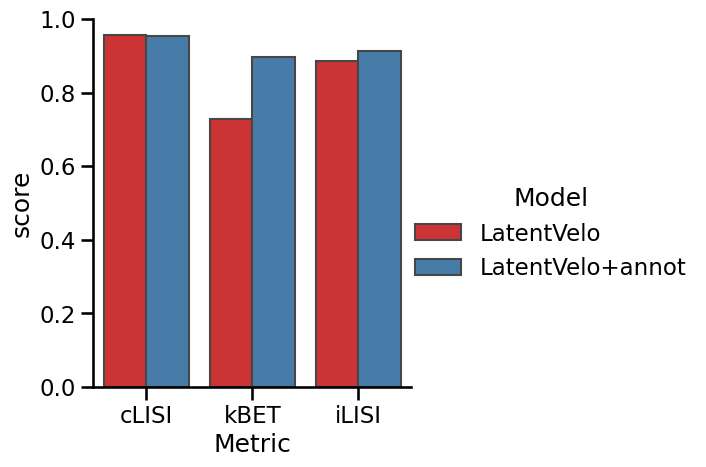

In [19]:
ltv.pl.integration_metrics([ge_metrics, annot_ge_metrics],
                           ['LatentVelo', 'LatentVelo+annot'],
                           edgecolor='#474747ff',height=5, aspect=1) # add annot
plt.show()

# Compute velocity batch correction metrics

In [20]:
cluster_edges = [('A', 'B'), ('A', 'C'),
                 ('C', 'E'), ('B', 'D')]

adata.layers['rna_velocity'] = adata.layers['rna_velocity'].todense()
adata.layers['gene_velocity'] = adata.layers['rna_velocity'].copy()
ltv.ev.format_benchmark_adata(adata, latent_adata, estimated_vkey='spliced_velocity')
vae_df = ltv.ev.benchmark_synthetic(adata, basis_list = ['latent'], batch_key='batch', 
                                               cluster_key='milestone', cluster_edges = cluster_edges)


ltv.ev.format_benchmark_adata(adata, annot_latent_adata, estimated_vkey='spliced_velocity')
annot_vae_df = ltv.ev.benchmark_synthetic(adata, basis_list = ['latent'], batch_key='batch', 
                                               cluster_key='milestone', cluster_edges = cluster_edges)

computing velocity embedding
    finished (0:00:01) --> added
    'spliced_velocity_pca', embedded velocity vectors (adata.obsm)
computing velocity embedding
    finished (0:00:00) --> added
    'spliced_velocity_pca_20', embedded velocity vectors (adata.obsm)
computing velocity embedding
    finished (0:00:00) --> added
    'spliced_velocity_pca_10', embedded velocity vectors (adata.obsm)
computing velocity embedding
    finished (0:00:00) --> added
    'spliced_velocity_pca_3', embedded velocity vectors (adata.obsm)
computing velocity embedding
    finished (0:00:00) --> added
    'spliced_velocity_umap', embedded velocity vectors (adata.obsm)
computing velocity graph (using 1/16 cores)


  0%|          | 0/2000 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'rna_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'rna_velocity_latent', embedded velocity vectors (adata.obsm)
computing velocity embedding
    finished (0:00:00) --> added
    'rna_velocity_pca', embedded velocity vectors (adata.obsm)
computing velocity embedding
    finished (0:00:00) --> added
    'rna_velocity_pca_20', embedded velocity vectors (adata.obsm)
computing velocity embedding
    finished (0:00:00) --> added
    'rna_velocity_pca_10', embedded velocity vectors (adata.obsm)
computing velocity embedding
    finished (0:00:00) --> added
    'rna_velocity_pca_3', embedded velocity vectors (adata.obsm)
computing velocity embedding
    finished (0:00:00) --> added
    'rna_velocity_umap', embedded velocity vectors (adata.obsm)
computing velocity embedding
    finished (0:00:00) --> added
    'spliced_velocity_pca', embedded velocity vectors (adata.obsm

  0%|          | 0/2000 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'rna_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'rna_velocity_latent', embedded velocity vectors (adata.obsm)
computing velocity embedding
    finished (0:00:01) --> added
    'rna_velocity_pca', embedded velocity vectors (adata.obsm)
computing velocity embedding
    finished (0:00:00) --> added
    'rna_velocity_pca_20', embedded velocity vectors (adata.obsm)
computing velocity embedding
    finished (0:00:00) --> added
    'rna_velocity_pca_10', embedded velocity vectors (adata.obsm)
computing velocity embedding
    finished (0:00:00) --> added
    'rna_velocity_pca_3', embedded velocity vectors (adata.obsm)
computing velocity embedding
    finished (0:00:00) --> added
    'rna_velocity_umap', embedded velocity vectors (adata.obsm)


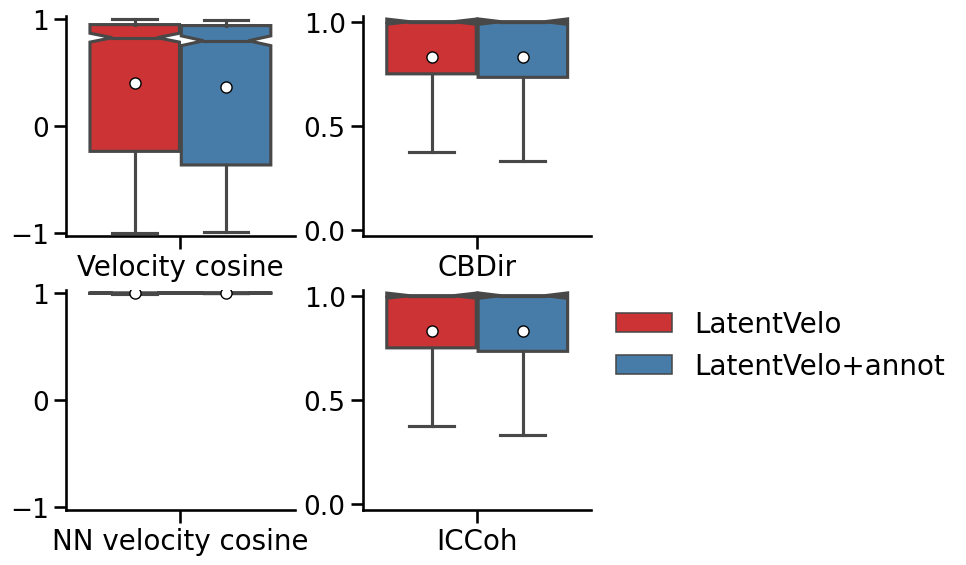

In [21]:
import seaborn as sns
ltv.pl.integration_velocity_metrics([vae_df, annot_vae_df],
                                     ['LatentVelo', 'LatentVelo+annot'],
                                     ['latent', 'latent'], figsize=(10,6), 
                                     palette=np.array(sns.color_palette("Set1").as_hex()),
                                    orient='v')
plt.show()